# Homework 6: Parallel Spectrogram
by Rustam Guseyn-zade ([link canvas](https://skoltech.instructure.com/courses/3546/users/9673))

## Table of contents
* [Spectrogram in parallel](#Spectogram-in-parallel)
* [Timings](#Timings)

In [1]:
# import needed libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import time

## Spectogram in parallel

In [2]:
%%writefile spectrogram.py
# Create file spectrogram.py
import math
import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

steps_in_t = 3**9+6
t = np.linspace(-20*2*math.pi, 20*2*math.pi, steps_in_t)
y=np.sin(t)*np.exp(-t**2/2/20**2)
y=y+np.sin(3*t)*np.exp(-(t-5*2*math.pi)**2/2/20**2)
y=y+np.sin(5.5*t)*np.exp(-(t-10*2*math.pi)**2/2/5**2)
y=y+np.sin(4*t)*np.exp(-(t-7*2*math.pi)**2/2/5**2)
    
nwindowsteps = 10000
window_positions= np.linspace(-20*2*math.pi, 20*2*math.pi, nwindowsteps)
window_width = 2.0*2*math.pi

chunk_size = len(window_positions)//size + 1
chunk_head = chunk_size * rank
chunk_tail = chunk_size * (rank + 1)
if chunk_tail > len(window_positions):
    chunk_tail = len(window_positions)

specgram = np.empty([len(t), chunk_tail-chunk_head])
for i, w in enumerate(window_positions[chunk_head:chunk_tail]):
    window_funtion = np.exp(-(t-w)**2/2/window_width**2)
    y_window = y * window_funtion
    specgram[:,i] = abs(np.fft.fft(y_window))

print(f"process {rank}: from {chunk_head} to {chunk_tail}")
  
all_specgram_patched = comm.gather((chunk_head, specgram),root=0)

if rank == 0:
    print(f"all shape: {specgram.shape}")
    for specgram_patch in sorted(all_specgram_patched)[1:]:
        specgram = np.concatenate((specgram, specgram_patch[1]), axis=1)
    
    fig, ax = plt.subplots()
    ax.set_ylim(0, 10)
    w=np.fft.fftfreq(len(y), d=(t[1]-t[0])/2/math.pi)
    im = ax.imshow(specgram, aspect='auto', origin='lower', extent=[min(t)/2/math.pi, max(t)/2/math.pi, y[0], 2 * w[int(len(w)/2)-1]])
    fig.set_size_inches(9, 7, forward=True)
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Time, cycles')
    ax.set_ylabel('Frequency')
    ax.title.set_text('Spectrogram')
#     plt.show()
    plt.savefig('spectrogram.png')

Overwriting spectrogram.py


In [3]:
!mpirun --allow-run-as-root -np 3 python3 spectrogram.py

process 1: from 3334 to 6668
process 2: from 6668 to 10000
process 0: from 0 to 3334
all shape: (19689, 3334)


Resulting plot could be found on `spectrogram.png` file

## Timings

Text(0.5, 1.0, 'Spectrogram mpi speedup')

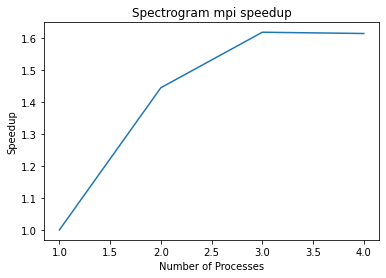

In [4]:
def measure_n_processes_time(processes_number, attempts=10):
    number_processes_time = []
    for i in range(attempts):
        start = time.time()
        !mpirun --allow-run-as-root -n {processes_number} python3 spectrogram.py >/dev/null 2>&1
        end = time.time()
        number_processes_time.append(end - start)
        print(f'measure attempt {i+1} from {attempts} for {processes_number} processes', end='\r')
    return sum(number_processes_time) / attempts

processes_times = [measure_n_processes_time(i) for i in range(1,5)]
speedups = [processes_times[0] / processes_times[i] for i in range(len(processes_times))]
plt.plot(range(1, 5), speedups)
plt.ylabel('Speedup')
plt.xlabel('Number of Processes')
plt.title('Spectrogram mpi speedup')